# Cumulative Cp Plot
This notebook shows how to use PyTecplot, Slice, Integration, and Layout files to compute longitutinal Cp. We also compute the cumulative Cp in the longitudinal direction and plot the results.

The first step is to import the necessary modules and create some convenience functions.

In [1]:
import tecplot as tp
from tecplot.constant import *
import numpy as np

def extract_x_slice(pos):
    zone = tp.data.extract.extract_slice(origin=(pos,0,0), normal=(1,0,0), source=SliceSource.SurfaceZones)
    return zone

def integrate(zone,var):
    zone_num = zone.index+1
    var_num = var.index+1
    tp.macro.execute_extended_command(command_processor_id='CFDAnalyzer4',
    command=f"Integrate [{zone_num}] VariableOption='Scalar' XOrigin=0 YOrigin=0 ZOrigin=0 ScalarVar={var_num} Absolute='F' ExcludeBlanked='F' XVariable=1 YVariable=2 ZVariable=3 IntegrateOver='Cells' IntegrateBy='Zones' PlotResults='F' PlotAs='Result' TimeMin=0 TimeMax=0")
    return float(tp.active_frame().aux_data["CFDA.INTEGRATION_TOTAL"])

## Load the raw data
First we load the raw data and display it to give a frame of reference

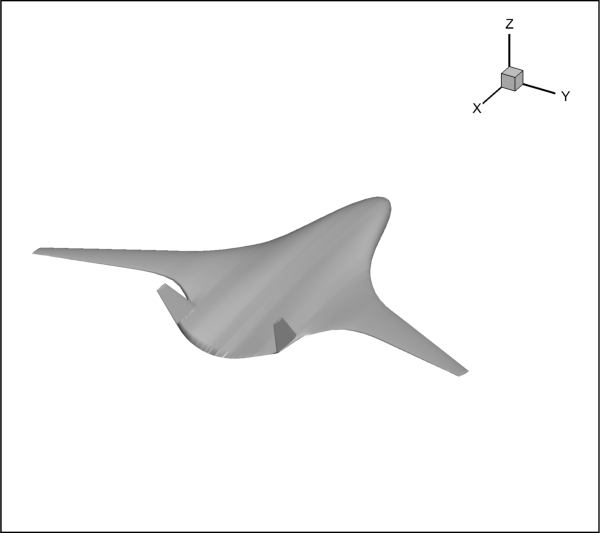

In [2]:
tp.new_layout()
ds = tp.data.load_tecplot("NASA_Blended_Wing.plt")
tp.active_frame().plot_type = PlotType.Cartesian3D
tp.extension.ipython.show()

## Use slices to compute longitudinal Cp
Now that the data are loaded, we determine min/max X-values for the data and extract slices at intervals in that range. We integrate Cp on each slice and retain the result in an array. We also compute the cumulative Cp.

In [3]:
results = list()
result_total = 0
var_to_integrate = ds.variable("Cp")
xmin,xmax = ds.variable(0).minmax()
for xpos in np.linspace(xmin, xmax, 50):
    print("Extracting slice at: ", xpos)
    zone = extract_x_slice(xpos)
    result = integrate(zone, var_to_integrate)
    results.append((xpos,result))
    # Compute the area under the curve of Cp at each step to get
    # cumulative Cp values
    result_total = np.trapz([n[1] for n in results], [n[0] for n in results])
    results[-1] = (xpos, result, result_total)

Extracting slice at:  0.0
Extracting slice at:  3.02856912244898
Extracting slice at:  6.05713824489796
Extracting slice at:  9.08570736734694
Extracting slice at:  12.11427648979592
Extracting slice at:  15.1428456122449
Extracting slice at:  18.17141473469388
Extracting slice at:  21.19998385714286
Extracting slice at:  24.22855297959184
Extracting slice at:  27.257122102040817
Extracting slice at:  30.2856912244898
Extracting slice at:  33.31426034693878
Extracting slice at:  36.34282946938776
Extracting slice at:  39.37139859183674
Extracting slice at:  42.39996771428572
Extracting slice at:  45.4285368367347
Extracting slice at:  48.45710595918368
Extracting slice at:  51.48567508163266
Extracting slice at:  54.514244204081635
Extracting slice at:  57.54281332653062
Extracting slice at:  60.5713824489796
Extracting slice at:  63.599951571428576
Extracting slice at:  66.62852069387756
Extracting slice at:  69.65708981632653
Extracting slice at:  72.68565893877552
Extracting slice a

## Create a new zone with the result
Here we add a new zone and new variable to store the results that we captured above. Once the data are added to the dataset we save a Tecplot PLT file with the results for easy access later.

In [4]:
# Create a new line zone with the results
ds.add_variable("Cumulative Cp")
result_zone = ds.add_ordered_zone("Cp_Total_Results", (len(results),1,1), locations=[ValueLocation.Nodal]*ds.num_variables)
result_zone.values('X')[:] = [n[0] for n in results]
result_zone.values('Cp')[:] = [n[1] for n in results]
result_zone.values('Cumulative Cp')[:] = [n[2] for n in results]
tp.data.save_tecplot_plt("NASA_Blended_Wing_CpResult.plt", zones=[result_zone], variables=[ds.variable('X'), ds.variable('Cp'), ds.variable('Cumulative Cp')])

Dataset(uid=53, frame=Frame(uid=44, page=Page(uid=35)))

## Compare the Cp integrated results
Here we're using Tecplot 360's integration as well as simple integration methods from numpy and scipy and comparing the results.

In [5]:
res = integrate(result_zone, var_to_integrate)
print("Tecplot 360 result:", res)

res = np.trapz([n[1] for n in results], [n[0] for n in results])
print("Numpy result:      ", res)

from scipy.integrate import simps
res = simps([n[1] for n in results], [n[0] for n in results])
print("Scipy result:      ", res)

Tecplot 360 result: -3769.27227685342
Numpy result:       -3769.272404406959
Scipy result:       -3763.6716536572494


## Create the final plot!
Since we have the original PLT file and the new PLT file we can skip writing a bunch of Python code to setup the plot style and simply use a layout file which references these two PLT files! 

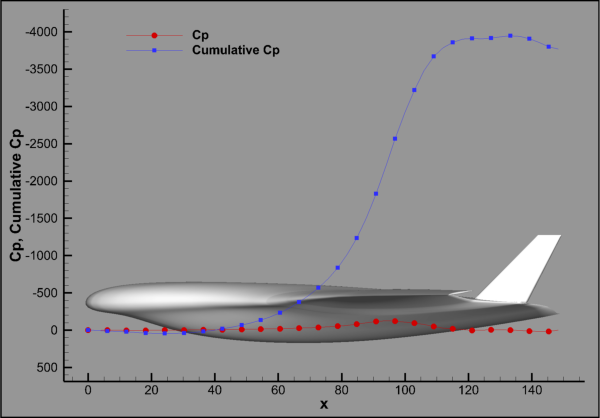

In [6]:
# Open a precreated layout that utilizes the data we just created.
tp.load_layout("NASA_Blended_Wing_CpResult.lay")
tp.extension.ipython.show()